In [ ]:
# To install pref_voting, run on command line:
# pip install pref_voting

In [18]:
import json
import pandas as pd
import numpy as np
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *
from pref_voting.iterative_methods import instant_runoff, coombs
from pref_voting.c1_methods import condorcet
from pref_voting.probabilistic_methods import *
import csv
from collections import Counter, defaultdict
from pref_voting.profiles import Profile


+-----+----+---+----+----+----+---+---+----+----+----+-----+-----+-----+----+----+-----+----+---+----+----+----+----+----+---+----+----+----+----+----+----+----+-----+----+---+----+----+----+----+----+----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-----+----+----+-----+----+----+----+----+
| 423 | 55 | 9 | 11 | 91 | 72 | 5 | 3 | 10 | 12 | 11 | 379 | 248 | 151 | 20 | 33 | 188 | 24 | 5 | 11 | 41 | 27 | 20 | 13 | 8 | 36 | 49 | 98 | 54 | 52 | 36 | 46 | 436 | 13 | 8 | 20 | 12 | 17 | 73 | 10 | 32 | 78 | 115 | 213 | 23 | 45 | 133 | 189 | 570 | 435 | 257 | 170 | 30 | 46 | 157 | 142 | 114 | 75 | 62 | 144 | 30 | 57 | 77 | 92 |
+-----+----+---+----+----+----+---+---+----+----+----+-----+-----+-----+----+----+-----+----+---+----+----+----+----+----+---+----+----+----+----+----+----+----+-----+----+---+----+----+----+----+----+----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-----+----+----+-----+----+----+----+----

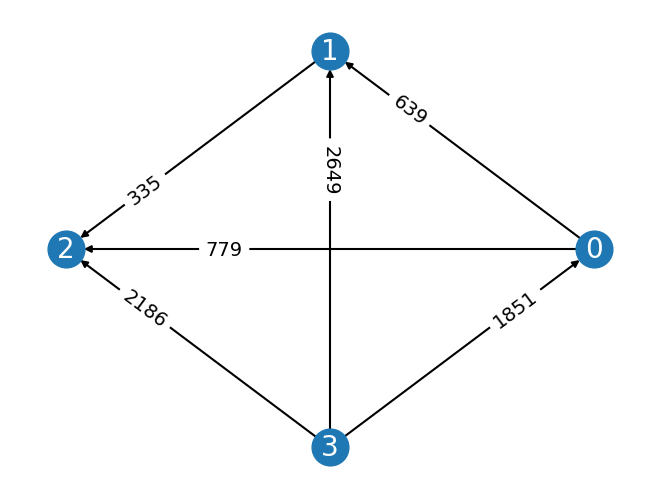

In [19]:
# Given rankings in candidate names and a candidate to index dictionary, 
# return the rankings using index instead
# eg. {'Candidate B': 0, 'Candidate A': 1, 'Candidate C': 2}, ('Candidate A', 'Candidate B', 'Candidate C')-> {1: 1, 0: 2, 2: 3}
def ranking_to_indices(ranking, candidate_to_index):
    ranking_dict = {}
    for rank, candidate in enumerate(ranking, start=1):
        ranking_dict[candidate_to_index.get(candidate, -1)] = rank
    return ranking_dict

def create_profile(file_path):
    # Create election dataframe
    election_data = pd.read_csv(file_path)
    column_names_list = election_data.columns.tolist()
    num_ranks=0

    # Find number of ranks based on column names
    for item in column_names_list:
        if 'rank' in item:
            num_ranks+=1

    # Loops through each row (one ballot) to extract the candidates and their corresponding rankings
    def process_rankings(row):
        seen_candidates = set() # ensure that a candidate is not ranked twice
        ranking = defaultdict(list)
        rank = 1
        
        for i in range(1, num_ranks+1):
            candidate = row[f'rank{i}']
            if candidate != 'overvote' and candidate != 'skipped' and candidate not in seen_candidates:
                ranking[rank].append(candidate) # saves a candidate as linked to a rank
                seen_candidates.add(candidate) # tracks that a candidate has been seen
                rank += 1
        
        # return statement turns this
        #     {
        #     1: ['Candidate A'], 
        #     2: ['Candidate B'], 
        #     3: ['Candidate C']
        # }
                        
        # to this
        # {
        #     'Candidate A': 1, 
        #     'Candidate B': 2, 
        #     'Candidate C': 3
        # }
        
        return {c: r for r, cs in ranking.items() for c in cs}

    # Save the results from process_rankings for each row into a new column
    election_data['processed_rankings'] = election_data.apply(process_rankings, axis=1)

    # Counts the number of occurances where a candidate is voted at a certain rank
    # Counter([
    #     (('Candidate A', 1), ('Candidate B', 2)),
    #     (('Candidate A', 1), ('Candidate B', 2)),
    #     (('Candidate B', 1)),
    #     (('Candidate B', 1), ('Candidate A', 2))
    # ])
    # turns into 
    # {
    #     (('Candidate A', 1), ('Candidate B', 2)): 2,
    #     (('Candidate B', 1), ('Candidate A', 2)): 2,
    #     (('Candidate B', 1)): 1
    # }
    ranking_counts = Counter(election_data['processed_rankings'].apply(tuple))

    # Create unique candidate list (works because set() ignores duplicates)
    candidates = [c for c in set().union(*[r for r in ranking_counts])]

    # Assign candidates an index for calculations 
    candidate_to_index = {candidate: index for index, candidate in enumerate(candidates)}

    # Create dictionary mapping index to candidates for later reference
    candidates_with_indices = {index: candidate for candidate, index in candidate_to_index.items()}

    # Creating rankings with indices. Looks like below.
    # [{0: 1}, {0: 1, 1: 2}, {2: 1, 1: 2}, {2: 1, 1: 2, 0: 3}]
    # - candidate 0 ranked first
    # - candidate 0 ranked first and candidate 1 ranked second
    # - candidate 2 ranked first and candidate 1 ranked second
    # - candidate 2 ranked first and candidate 1 ranked second and candidate 0 ranked third
    rankings = [ranking_to_indices(ranking, candidate_to_index) for ranking, count in ranking_counts.items()]

    # Generate an array of how many votes of a particular ballot behaviour there are
    # {
    #     (('Candidate A', 1), ('Candidate B', 2)): 2,
    #     (('Candidate B', 1), ('Candidate A', 2)): 2,
    #     (('Candidate B', 1)): 1
    # }
    # turns into [2, 2, 1]
    rcounts = [count for ranking, count in ranking_counts.items()]

    # Create ProfileWithTies object
    # We need this because we have ballots that are incomplete (or as the package calls truncated) which means that not all candidates were ranked
    profile = ProfileWithTies(rankings, rcounts)
    profile.display()

    # Treat unranked candidates as tied for last place below ranked candidates for the purposes of the margin graph
    profile.use_extended_strict_preference()

    # Display the margin graph
    profile.display_margin_graph()

    return profile

profile = create_profile('/Users/belle/Desktop/build/rcv_proposal/scotland/processed_data/aberdeen2017/AiryhallBroomhillGarthdeeWard_aberdeen17-11.csv')

In [21]:
def run_voting_methods(profile):
    data = {}
    ## PLURALITY ##
    # The Plurality score of a candidate c is the number of voters that rank c in first place. 
    # The Plurality winners are the candidates with the largest Plurality score in the profile.
    plurality.display(profile)
    data['plurality'] = plurality(profile)[0]

    ## Plurality With Runoff PUT ##
    # If there is a majority winner then that candidate is the Plurality with Runoff winner. 
    # Otherwise hold a runoff between the top two candidates: the candidate with the most first place votes 
    # and the candidate with the 2nd most first place votes (or perhaps tied for the most first place votes). 
    # In the case of multiple candidates tied for the most or 2nd most first place votes, use parallel-universe 
    # tiebreaking: a candidate is a Plurality with Runoff winner if it is a winner in some runoff as described. 
    # If the candidates are all tied for the most first place votes, then all candidates are winners.
    plurality_with_runoff_put.display(profile)
    data['plurality_with_runoff_put'] = plurality_with_runoff_put(profile)[0]

    ## Instant Runoff for Truncated Linear Orders ##
    # Iteratively remove the candidates with the fewest number of first place votes, until there is a candidate 
    # with more than the threshold number of first-place votes. If a threshold is not set, then it is strictly 
    # more than half of the non-empty ballots.
    instant_runoff_for_truncated_linear_orders.display(profile)
    data['instant_runoff_for_truncated_linear_orders'] = instant_runoff_for_truncated_linear_orders(profile)[0]

    ## Bottom-Two-Runoff Instant Runoff PUT ##
    # Find the two candidates with the lowest two plurality scores, remove the one 
    # who loses head-to-head to the other, and repeat until a single candidate remains. 
    # Parallel-universe tiebreaking is used to break ties for lowest or second lowest plurality scores.
    bottom_two_runoff_instant_runoff_put.display(profile)
    data['bottom_two_runoff_instant_runoff_put'] = bottom_two_runoff_instant_runoff_put(profile)[0]

    ## Instant Runoff PUT ##
    # Instant Runoff (instant_runoff()) with parallel universe tie-breaking (PUT), defined recursively: 
    # if there is a candidate with a strict majority of first-place votes, that candidate is the IRV-PUT winner; 
    # otherwise a candidate x is an IRV-PUT winner if there is some candidate y with a minimal number of 
    # first-place votes such that after removing y from the profile, x is an IRV-PUT winner.
    instant_runoff_put.display(profile)
    data['instant_runoff_put'] = instant_runoff_put(profile)[0]

    ## BORDA ##
    # Borda score for truncated linear orders using different ways of defining the Borda score for truncated linear orders.
    borda_for_profile_with_ties.display(profile)
    data['borda_for_profile_with_ties'] = borda_for_profile_with_ties(profile)[0]

    ## To be added: BUCKLIN (currently runs into AttributeError: 'ProfileWithTies' object has no attribute '_rcounts') ##

    ## CONDORCET ##
    # Return the Condorcet winner if one exists, otherwise return all the candidates. A Condorcet winner is a candidate c
    # that is majority preferred to every other candidate c
    condorcet.display(profile)
    data['condorcet'] = condorcet(profile)[0]

    ## CONDORCET IRV ##
    # If a Condorcet winner exists, elect that candidate, otherwise return the instant runoff winners.
    condorcet_irv.display(profile)
    data['condorcet_irv'] = condorcet_irv(profile)[0]

    ## WEAK CONDORCET ##
    # Return all weak Condorcet winner if one exists, otherwise return all the candidates. A weak Condorcet winner is a candidate 
    # c such that no other candidate is majority preferred to c.
    weak_condorcet.display(profile)
    data['weak_condorcet'] = weak_condorcet(profile)[0]

    ## BENHAM ##
    # As long as the profile has no Condorcet winner, eliminate the candidate with the lowest plurality score.
    benham.display(profile)
    data['benham'] = benham(profile)[0]

    ## MINIMAX ##
    # The Minimax winners are the candidates with the smallest maximum pairwise loss.  
    # That is, for each candidate a, find the biggest margin of a candidate 
    # a over b, then elect the candidate(s) with the smallest such loss. Also known as the Simpson-Kramer Rule.
    minimax.display(profile)
    data['minimax'] = minimax(profile)[0]

    ## Ranked Pairs ##
    # Order the edges in the margin graph from largest to smallest and lock them in in that order, 
    # skipping edges that create a cycle. If there are ties in the margins, break the ties using a 
    # tie-breaking rule: a linear ordering over the edges. A candidate is a Ranked Pairs winner if 
    # it wins according to some tie-breaking rule. Also known as Tideman’s Rule.
    ranked_pairs.display(profile)
    data['ranked_pairs'] = ranked_pairs(profile)[0]

    ## TOP CYCLE ##
    # The smallest set of candidates such that every candidate inside the set is majority preferred to every candidate outside the set.
    top_cycle.display(profile)
    data['top_cycle'] = top_cycle(profile)[0]

    ## COPELAND ##
    # The Copeland score for c is the number of candidates that c is majority preferred to minus the number of candidates majority preferred to c. 
    # The Copeland winners are the candidates with the maximum Copeland score in the profile restricted to curr_cands.
    if len(copeland(profile))==1:
        copeland.display(profile)
        data['copeland'] = copeland(profile)[0]

    ## DAUNOU ##
    # Implementation of Daunou’s voting method as described in the paper: https://link.springer.com/article/10.1007/s00355-020-01276-w
    daunou(profile)
    data['daunou'] = daunou(profile)[0]

    random_dictator.display(profile)

    return data

data = run_voting_methods(profile)
print(data)

Plurality winner is {3}
PluralityWRunoff PUT winner is {3}
Instant Runoff (Truncated Linear Orders) winner is {3}
Bottom-Two-Runoff Instant Runoff PUT winner is {3}
Instant Runoff PUT winner is {3}
Borda (for Truncated Profiles) winner is {3}
Condorcet winner is {3}
Condorcet IRV winner is {3}
Weak Condorcet winner is {3}
Benham winner is {3}
Minimax winner is {3}
Ranked Pairs winner is {3}
Top Cycle winner is {3}
Copeland winner is {3}
Random Dictator probability is {0: 0.251, 1: 0.116, 2: 0.232, 3: 0.402}
{'plurality': 3, 'plurality_with_runoff_put': 3, 'instant_runoff_for_truncated_linear_orders': 3, 'bottom_two_runoff_instant_runoff_put': 3, 'instant_runoff_put': 3, 'borda_for_profile_with_ties': 3, 'condorcet': 3, 'condorcet_irv': 3, 'weak_condorcet': 3, 'benham': 3, 'minimax': 3, 'ranked_pairs': 3, 'top_cycle': 3, 'copeland': 3, 'daunou': 3}
